# Estimating the CAPM

## How to do it

### 1. Import the libraries

In [15]:
import numpy as np
import yfinance as yf
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

### 2. Specify the risky asset, the benchmark, and the time horizon.

In [2]:
RISKY_ASSET = 'AMZN'
MARKET_BENCHMARK = '^GSPC'
START_DATE = '2016-01-01'
END_DATE = '2020-12-31'

### 3. Download the necessary data from Yahoo Finance.

In [4]:
df = yf.download(
    tickers=[RISKY_ASSET, MARKET_BENCHMARK],
    start=START_DATE,
    end=END_DATE,
    # adjusted=True,
    progress=False
)

### 4. Resample to monthly data and calculate the simple returns.

In [6]:
X = (
    df['Adj Close']
    .rename(columns={RISKY_ASSET: 'asset', MARKET_BENCHMARK: 'market'})
    .resample('M')
    .last()
    .pct_change()
    .dropna()
)

### 5. Calculate beta using the covariance approach

In [11]:
covariance = X.cov().iloc[0, 1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance
print(f'beta = {beta:.4f}')

beta = 1.1537


### 6. Prepare the input and estimate the CAPM as a linear regression

In [12]:
# separate target
y = X.pop('asset')

# add constant
X = sm.add_constant(X)

# define and fit the regression model
capm_model = sm.OLS(y, X).fit()

# print reuslts
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     36.15
Date:                Wed, 19 Jul 2023   Prob (F-statistic):           1.37e-07
Time:                        01:12:36   Log-Likelihood:                 79.803
No. Observations:                  59   AIC:                            -155.6
Df Residuals:                      57   BIC:                            -151.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.009      2.182      0.0

In [14]:
# Or, using the formula notation

import statsmodels.formula.api as smf

# return step 4 to have a DF with columns : 'asset' and 'market'
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset', MARKET_BENCHMARK: 'market'}).resample('M').last().pct_change().dropna()

# define and fit the regression model
capm_model = smf.ols(formula='asset ~ market', data=X).fit()

# print results
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     36.15
Date:                Wed, 19 Jul 2023   Prob (F-statistic):           1.37e-07
Time:                        01:15:13   Log-Likelihood:                 79.803
No. Observations:                  59   AIC:                            -155.6
Df Residuals:                      57   BIC:                            -151.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0188      0.009      2.182      0.0

### Using the 13-Week T-bill

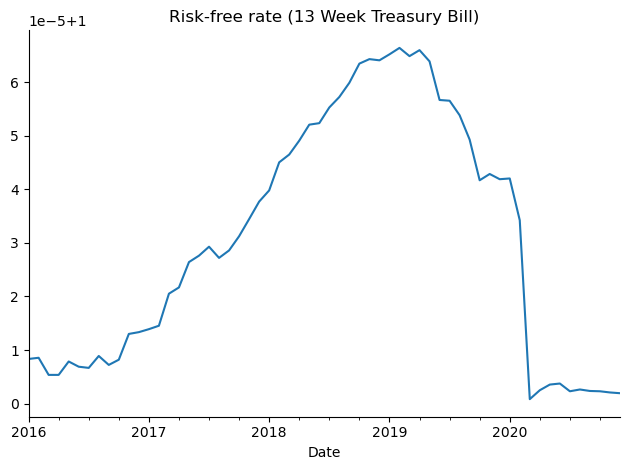

In [17]:
# period length in days
N_DAYS = 90    # 13 weeks = 3 months

# download data from Yahoo Finance
df_rf = yf.download("^IRX",
                    start=START_DATE,
                    end=END_DATE,
                    progress=False)

# resample to monthly frequency by taking the last value of each month
rf = df_rf.resample('M').last().Close / 100

# calculate the corresponding daily risk-free rate
rf = (1 / (1 - rf * N_DAYS / 360)) ** (1 / N_DAYS)

# conver to monthly and substract 1
rt = (rf ** 30) - 1

# plot the risk-free rate
rf.plot(title='Risk-free rate (13 Week Treasury Bill)')

sns.despine()
plt.tight_layout()


### Using the 3-month T-bill from the FRED database

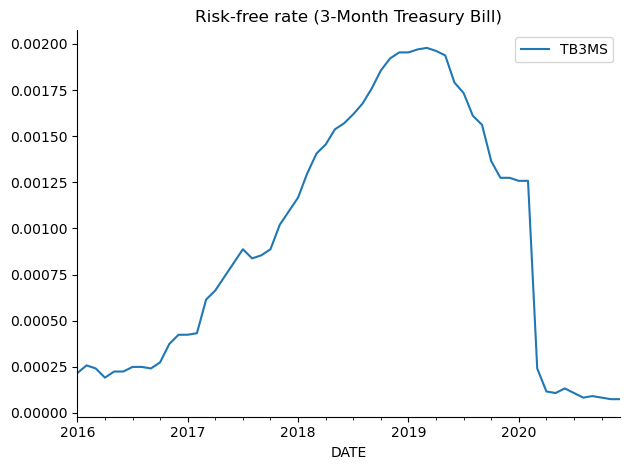

In [20]:
import pandas_datareader.data as web

# download the data
rf = web.DataReader(
    "TB3MS", "fred", start=START_DATE, end=END_DATE
)

# convert to monthly
rf = (1 + (rf / 100)) ** (1 / 12) - 1

# plot the risk-free rate
rf.plot(title='Risk-free rate (3-Month Treasury Bill)')

sns.despine()
plt.tight_layout()

# Estimating the Fama-French three-factor model

## How to do it

### 1. Import the libraries

In [21]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

### 2. Define parameters

In [22]:
RISKY_ASSET = 'AAPL'
START_DATE = '2016-01-01'
END_DATE = '2020-12-31'

### 3. Download the dataset containing the risk factors

In [23]:
ff_dict = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=START_DATE, end=END_DATE)

In [24]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

In [25]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202305 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2023 Kenneth R. French

  0 : (60 rows x 4 cols)
  1 : Annual Factors: January-December (5 rows x 4 cols)


### 4. Select the appropriate dataset and divide the values by 100

In [26]:
factors_3_df = ff_dict[0].rename(columns={'Mkt-RF': 'MKT'}).div(100)
factors_3_df.head()

,MKT,SMB,HML,RF
Date,,,,
2016-01,-0.0577,-0.0343,0.0209,0.0001
2016-02,-0.0007,0.0071,-0.0057,0.0002
2016-03,0.0696,0.0082,0.0119,0.0002
2016-04,0.0091,0.0074,0.0328,0.0001
2016-05,0.0178,-0.0018,-0.0166,0.0001


### 5. Download the prices the risky asset

In [27]:
asset_df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, progress=False)

### 6. Calculate the monthly returns on the risky asset

In [29]:
y = asset_df['Adj Close'].resample('M').last().pct_change().dropna()
y.index = y.index.to_period('m')
y.name = 'rtn'
y

Date
2016-02   -0.001287
2016-03    0.127211
2016-04   -0.139921
2016-05    0.071773
2016-06   -0.042660
2016-07    0.090063
2016-08    0.023652
2016-09    0.065504
2016-10    0.004334
2016-11   -0.021601
2016-12    0.047955
2017-01    0.047746
2017-02    0.133778
2017-03    0.048690
2017-04   -0.000070
2017-05    0.067807
2017-06   -0.057214
2017-07    0.032704
2017-08    0.106999
2017-09   -0.060244
2017-10    0.096808
2017-11    0.020278
2017-12   -0.015246
2018-01   -0.010637
2018-02    0.068185
2018-03   -0.058051
2018-04   -0.015020
2018-05    0.135124
2018-06   -0.009418
2018-07    0.027983
2018-08    0.200422
2018-09   -0.008303
2018-10   -0.030478
2018-11   -0.181198
2018-12   -0.116698
2019-01    0.055154
2019-02    0.044777
2019-03    0.097026
2019-04    0.056436
2019-05   -0.124213
2019-06    0.130519
2019-07    0.076395
2019-08   -0.016461
2019-09    0.072961
2019-10    0.110685
2019-11    0.077554
2019-12    0.098784
2020-01    0.054010
2020-02   -0.114701
2020-03   -0.06

### 7. Merge the datasets and calculate the excess returns

In [30]:
factors_3_df = factors_3_df.join(y)
factors_3_df['ecxess_rtn'] = (
    factors_3_df['rtn'] - factors_3_df['RF']
)
factors_3_df.head()

,MKT,SMB,HML,RF,rtn,ecxess_rtn
Date,,,,,,
2016-01,-0.0577,-0.0343,0.0209,0.0001,NaN,NaN
2016-02,-0.0007,0.0071,-0.0057,0.0002,-0.001287,-0.001487
2016-03,0.0696,0.0082,0.0119,0.0002,0.127211,0.127011
2016-04,0.0091,0.0074,0.0328,0.0001,-0.139921,-0.140021
2016-05,0.0178,-0.0018,-0.0166,0.0001,0.071773,0.071673


### 8. Estimate the three-factor model

In [31]:
ff_model = smf.ols(formula='ecxess_rtn ~ MKT + SMB + HML', data=factors_3_df).fit()
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             ecxess_rtn   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     17.83
Date:                Wed, 19 Jul 2023   Prob (F-statistic):           3.31e-08
Time:                        22:46:39   Log-Likelihood:                 80.949
No. Observations:                  59   AIC:                            -153.9
Df Residuals:                      55   BIC:                            -145.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0085      0.009      0.933      0.3

## There's more

In [32]:
from pandas_datareader.famafrench import get_available_datasets
get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

# Estimating the folling three-factor model on a porfolo of asset

## How to do it

### 1. Import the libraries

In [33]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

### 2. Define the parameters

In [36]:
ASSETS = ['AMZN', 'GOOG', 'AAPL', 'MSFT']
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = '2010-01-01'
END_DATE = '2020-12-31'

### 3. Download the factor related data

In [38]:
factors_3_df = web.DataReader(
    'F-F_Research_Data_Factors', 'famafrench', start=START_DATE, end=END_DATE
)[0]
factors_3_df = factors_3_df.div(100)

### 4. Download the prices of risky assets from Yahoo Finance

In [39]:
asset_df = yf.download(ASSETS, start=START_DATE, end=END_DATE, progress=False)

print(f"Downloaded {asset_df.shape[0]} rows of data.")

Downloaded 2768 rows of data.


### 5. Calculate the monthly returns on the risky assets

In [40]:
asset_df = asset_df['Adj Close'].resample('M').last().pct_change().dropna()

asset_df.index = asset_df.index.to_period('m')

### 6. Calculate the portfolio returns

In [41]:
asset_df['portfolio_returns'] = np.matmul(
    asset_df[ASSETS].values, WEIGHTS
)

In [43]:
asset_df.head()

,AAPL,AMZN,GOOG,MSFT,portfolio_returns
Date,,,,,
2010-02,0.065396,-0.055897,-0.005925,0.022146,0.006430
2010-03,0.148470,0.146706,0.076538,0.021626,0.098335
2010-04,0.111021,0.009796,-0.073036,0.042677,0.022615
2010-05,-0.016125,-0.084902,-0.076222,-0.151395,-0.082161
2010-06,-0.020827,-0.129125,-0.083768,-0.108139,-0.085465


<Axes: xlabel='Date'>

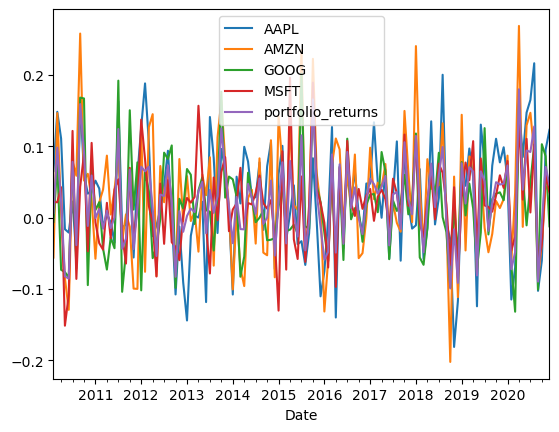

In [44]:
asset_df.plot()

### 7. Merge the datasets

In [42]:
factors_3_df = asset_df.join(factors_3_df).drop(ASSETS, axis=1)
factors_3_df.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
factors_3_df['portf_ex_rtn'] = (
    factors_3_df['portf_rtn'] - factors_3_df['rf']
)

### 8. Define a function for the rolling $n$-factor model

In [46]:
def rolloing_factor_model(input_data, formula, window_size):
     
    """
    Functions for estimating the Fama-French factor (n-factor) model using a rolling window fixed size.

    Parameters
    ------------
    input_data : pd.DataFrame
        A DataFrame containing the factors and asset/portfolio returns.
    formula : str
        'statsmodels' compatible foramula representing the OLS regression
    window_size : int
        Rolling window length
    
    Returns
    -----------
    coeffs_df : pd.DataFrame
        DataFrame containing the intercept and the three factors for each iteration

    """

    coeffs = []

    for stat_ind in range(len(input_data) - window_size + 1):
        end_ind = stat_ind + window_size

        # define and fit the regresion model
        ff_model = smf.ols(
            formula=formula,
            data=input_data[stat_ind:end_ind]
        ).fit()

        # store coefficients
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(
        coeffs,
        index=input_data.index[window_size - 1:]
    )

    return coeffs_df

### 9. Estimate the rolling three-factor model and plot the results

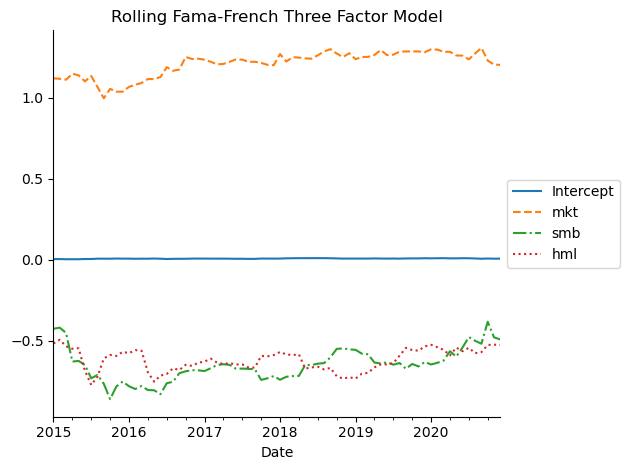

In [51]:
MODEL_FORMULA = 'portf_ex_rtn ~ mkt + smb + hml'
results_df = rolloing_factor_model(
    factors_3_df,
    MODEL_FORMULA,
    window_size=60
)
(
    results_df
    .plot(title="Rolling Fama-French Three Factor Model",
          style=['-', '--', '-.', ':'])
    .legend(loc='center left', bbox_to_anchor=(1, 0.5))
)

sns.despine()
plt.tight_layout()

# Estimating the four- and five-factor models

## How to do it

### 1. Import the libraries

In [52]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

### 2. Specify the risky asset and the time horizon

In [53]:
RISKY_ASSET = 'AMZN'
START_DATE = '2016-01-01'
END_DATE = '2020-12-31'

### 3. Download the risk factors from Prof. French’s website

In [54]:
# three factors
factors_3_df = web.DataReader(
    'F-F_Research_Data_Factors', 
    'famafrench', start=START_DATE, 
    end=END_DATE)[0]

# momentum factor
momentum_df = web.DataReader(
    'F-F_Momentum_Factor',
    'famafrench', 
    start=START_DATE,
    end=END_DATE)[0]

# five fators
factors_5_df = web.DataReader(
    'F-F_Research_Data_5_Factors_2x3',
    'famafrench',
    start=START_DATE,
    end=END_DATE)[0]

### 4. Download the data of the risky asset from Yahoo Finance

In [57]:
asset_df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, progress=False)
print(f'Download {asset_df.shape[0]} rows of data.')

Download 1258 rows of data.


### 5. Calculate monthly returns

In [58]:
y = asset_df['Adj Close'].resample('M').last().pct_change().dropna()
y.index = y.index.to_period('m')
y.name = 'rtn'

### 6. Merge the datasets for the four-factor models

In [59]:
# jouin all datasets on the index
factors_4_df = factors_3_df.join(momentum_df).join(y)

# rename columns
factors_4_df.columns = ['mkt', 'smb', 'hml', 'rf', 'mom', 'rtn']

# divide everything (except returns) by 100
factors_4_df.loc[:, factors_4_df.columns != 'rtn'] /= 100

# calculate excess returns
factors_4_df['excess_rtn'] = (
    factors_4_df['rtn'] - factors_4_df['rf']
)

factors_4_df.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
Date,,,,,,,
2016-01,-0.0577,-0.0343,0.0209,0.0001,0.0144,NaN,NaN
2016-02,-0.0007,0.0071,-0.0057,0.0002,-0.0438,-0.058739,-0.058939
2016-03,0.0696,0.0082,0.0119,0.0002,-0.0501,0.074423,0.074223
2016-04,0.0091,0.0074,0.0328,0.0001,-0.0602,0.111094,0.110994
2016-05,0.0178,-0.0018,-0.0166,0.0001,0.0142,0.095817,0.095717


### 7. Merge the datasets for the five-factor models

In [60]:
# join all datasets on the index
factors_5_df = factors_5_df.join(y)

# rename columns
factors_5_df.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 'rf', 'rtn']

# divide everything (except returns) by 100
factors_5_df.loc[:, factors_5_df.columns != 'rtn'] /= 100

# calculate excess returns
factors_5_df['excess_rtn'] = (
    factors_5_df['rtn'] - factors_5_df['rf']
)

factors_5_df.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
Date,,,,,,,,
2016-01,-0.0577,-0.0348,0.0209,0.0280,0.0307,0.0001,NaN,NaN
2016-02,-0.0007,0.0085,-0.0057,0.0328,0.0199,0.0002,-0.058739,-0.058939
2016-03,0.0696,0.0108,0.0119,0.0076,-0.0004,0.0002,0.074423,0.074223
2016-04,0.0091,0.0122,0.0328,-0.0292,0.0186,0.0001,0.111094,0.110994
2016-05,0.0178,-0.0062,-0.0166,-0.0107,-0.0249,0.0001,0.095817,0.095717


### 8. Estimate the four-factor model

In [62]:
four_factor_model = smf.ols(
    formula='excess_rtn ~ mkt + smb + hml + mom',
    data=factors_4_df
).fit()

print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     16.03
Date:                Sat, 22 Jul 2023   Prob (F-statistic):           1.04e-08
Time:                        15:09:45   Log-Likelihood:                 88.316
No. Observations:                  59   AIC:                            -166.6
Df Residuals:                      54   BIC:                            -156.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0073      0.008      0.896      0.3

### 9. Estimate the five-factor model

In [63]:
five_factor_model = smf.ols(
    formula='excess_rtn ~ mkt + smb + hml + rmw + cma',
    data=factors_5_df
).fit()
print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     14.97
Date:                Sat, 22 Jul 2023   Prob (F-statistic):           3.77e-09
Time:                        15:12:09   Log-Likelihood:                 91.193
No. Observations:                  59   AIC:                            -170.4
Df Residuals:                      53   BIC:                            -157.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0067      0.008      0.856      0.3

# Estimating cross-sectional factor models using using the Fama MacBeth regression

## How to do it

### 1. Import the libraries

In [64]:
import pandas as pd
import pandas_datareader.data as web
from linearmodels.asset_pricing import LinearFactorModel

### 2. Specify the time horizon

In [65]:
START_DATE = '2010'
END_DATE = '2020-12'

### 3. Download and adjust the risk factors from Prof. French’s website

In [66]:
factor_5_df = (
    web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=START_DATE, end=END_DATE)[0]
    .div(100)
)

In [68]:
factor_5_df.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2010-01,-0.0336,0.0034,0.0043,-0.0127,0.0046,0.0000
2010-02,0.0340,0.0151,0.0323,-0.0027,0.0143,0.0000
2010-03,0.0631,0.0185,0.0221,-0.0065,0.0169,0.0001
2010-04,0.0200,0.0498,0.0289,0.0069,0.0172,0.0001
2010-05,-0.0789,0.0004,-0.0244,0.0130,-0.0022,0.0001


### 4. Download and adjust the returns of 12 industry Portfolios from Prof. French's website

In [69]:
portfolio_df = (
    web.DataReader(
        '12_Industry_Portfolios', 
        'famafrench',
        start=START_DATE,
        end=END_DATE)[0]
    .div(100)
    .sub(factor_5_df['RF'], axis=0)
)


In [70]:
portfolio_df.head()

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
2010-01,-0.0233,-0.0094,-0.0436,-0.0489,-0.0109,-0.0793,-0.0670,-0.0449,-0.0185,-0.0001,-0.0107,-0.0256
2010-02,0.0272,0.0738,0.0583,0.0256,0.0413,0.0481,0.0285,-0.0041,0.0429,0.0038,0.0270,0.0465
2010-03,0.0597,0.0948,0.0779,0.0323,0.0410,0.0666,0.0759,0.0312,0.0623,0.0360,0.0816,0.0886
2010-04,-0.0094,0.0748,0.0422,0.0404,0.0127,0.0220,0.0358,0.0284,0.0255,-0.0223,0.0092,0.0430
2010-05,-0.0569,-0.0900,-0.0920,-0.1023,-0.0677,-0.0769,-0.0582,-0.0630,-0.0535,-0.0802,-0.0922,-0.0822


### 5. Drop the risk-free rate from the factor dataset

In [71]:
factor_5_df = factor_5_df.drop('RF', axis=1)

### 6. Estimate the Fama-MacBeth regression and print the summary

In [72]:
five_factor_model = LinearFactorModel(
    portfolios=portfolio_df,
    factors=factor_5_df
)
result = five_factor_model.fit()
print(result)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 12   R-squared:                      0.7907
No. Factors:                          5   J-statistic:                    9.8773
No. Observations:                   132   P-value                         0.1956
Date:                  Sat, Jul 22 2023   Distribution:                  chi2(7)
Time:                          16:33:39                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.0123     0.0038     3.2644     0.0011      0.0049      0.0198
SMB           -0.0064     0.0052    

In [73]:
print(result.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 12   R-squared:                      0.7907
No. Factors:                          5   J-statistic:                    9.8773
No. Observations:                   132   P-value                         0.1956
Date:                  Sat, Jul 22 2023   Distribution:                  chi2(7)
Time:                          16:33:39                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.0123     0.0038     3.2644     0.0011      0.0049      0.0198
SMB           -0.0064     0.0052    

## There's more

### 1. Import the libraries

In [74]:
from statsmodels.api import OLS, add_constant

### 2. First step - estimate the factor loadings

In [75]:
factor_loadings = []
for portfolio in portfolio_df:
    reg_1 = OLS(
        endog=portfolio_df.loc[:, portfolio],
        exog=add_constant(factor_5_df)
    ).fit()
    factor_loadings.append(reg_1.params.drop('const'))

### 3. Store the factor loadings in a DataFrame

In [76]:
factor_load_df = pd.DataFrame(
    factor_loadings,
    columns=factor_5_df.columns,
    index=portfolio_df.columns
)
factor_load_df.head()

,Mkt-RF,SMB,HML,RMW,CMA
NoDur,0.785261,-0.215050,-0.083834,0.465619,0.337675
Durbl,1.549702,0.580415,-0.178435,0.290703,0.330191
Manuf,1.094488,0.291587,0.148479,0.087308,-0.017980
Enrgy,1.246375,0.493089,0.633344,0.254618,0.397847
Chems,0.884598,-0.089070,-0.016630,0.174612,0.204666


### 4. Second step - estimate the risk premia

In [77]:
risk_premia = []
for period in portfolio_df.index:
    reg_2 = OLS(
        endog=portfolio_df.loc[period, factor_load_df.index], 
        exog=factor_load_df
    ).fit()
    risk_premia.append(reg_2.params)

### 5. Store the risk premia in a DataFrame 

In [83]:
risk_premia = pd.DataFrame(
    risk_premia,
    index=portfolio_df.index,
    columns=factor_load_df.columns.to_list()
)
risk_premia.head()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01,-0.032718,0.051430,-0.023410,-0.039959,0.015858
2010-02,0.036721,0.021244,-0.015056,0.026525,-0.028951
2010-03,0.066002,-0.032164,-0.003095,-0.002901,0.000156
2010-04,0.019555,0.048464,0.009068,0.039828,-0.013978
2010-05,-0.076896,0.024534,-0.021948,0.020309,-0.013363


### 6. Calculate the average risk premia

In [84]:
risk_premia.mean()

Mkt-RF    0.012344
SMB      -0.006353
HML      -0.008900
RMW      -0.001041
CMA      -0.002317
dtype: float64